# Split into Train / Valid / Test set

## Load Dataset from sklearn

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [28]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()

In [29]:
df = pd.DataFrame(california.data, columns=california.feature_names)
df["Target"] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


## Convert to PyTorch Tensor

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [31]:
data = torch.from_numpy(df.values).float()

x = data[:, :-1]
y = data[:, -1:]

print(x.size(), y.size())

torch.Size([20640, 8]) torch.Size([20640, 1])


In [32]:
# Train / Valid / Test ratio
ratios = [.6, .2, .2]

In [33]:
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

Train 12384 / Valid 4128 / Test 4128 samples.


In [34]:
print(data.size())
print(data.size(0)) #데이터 셋의 샘플 수 

torch.Size([20640, 9])
20640


In [35]:
# Shuffle before split.
indices = torch.randperm(data.size(0))
# 데이터셋의 인덱스를 무작위로 섞기

x = torch.index_select(x, dim=0, index=indices)
# 섞인 index 에 따라 x 데이터 (특징) 재정렬 
y = torch.index_select(y, dim=0, index=indices)

print(x)
print()
print(y)
print(x.size(), y.size())


tensor([[   3.2981,   52.0000,    3.9533,  ...,    1.8514,   37.7700,
         -122.4300],
        [   2.8940,   52.0000,    4.1579,  ...,    2.2462,   37.3300,
         -121.9100],
        [   3.8125,   30.0000,    4.7707,  ...,    2.0902,   37.3700,
         -122.0300],
        ...,
        [   7.3750,   21.0000,    6.5300,  ...,    2.9700,   37.3400,
         -121.7800],
        [   3.8333,   34.0000,    4.6762,  ...,    3.2540,   33.9200,
         -117.8900],
        [   3.1061,   19.0000,    5.4901,  ...,    2.4503,   39.7600,
         -121.5800]])

tensor([[2.2270],
        [2.0950],
        [3.2500],
        ...,
        [3.3840],
        [1.7040],
        [1.1020]])
torch.Size([20640, 8]) torch.Size([20640, 1])


In [36]:
# Split train, valid and test set with each count.
x = list(x.split(cnts, dim=0))
# torch.Tensor.split 메서드는 텐서의 튜플임 >> 리스트로 변환 
# cnts 를 기반, x 데이터를 chunks로 분할 
y = y.split(cnts, dim=0)


for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


## Preprocessing

In [37]:
x[0]  # train set 

tensor([[   3.2981,   52.0000,    3.9533,  ...,    1.8514,   37.7700,
         -122.4300],
        [   2.8940,   52.0000,    4.1579,  ...,    2.2462,   37.3300,
         -121.9100],
        [   3.8125,   30.0000,    4.7707,  ...,    2.0902,   37.3700,
         -122.0300],
        ...,
        [   3.7132,   15.0000,    5.1908,  ...,    2.5898,   38.4300,
         -122.7300],
        [   3.4291,    6.0000,    4.8042,  ...,    2.1685,   38.6100,
         -121.4900],
        [   2.9453,   26.0000,    5.4119,  ...,    2.6762,   38.3900,
         -122.8000]])

In [38]:
scaler = StandardScaler()
scaler.fit(x[0].numpy()) # You must fit with train data only.

x[0] = torch.from_numpy(scaler.transform(x[0].numpy())).float()
x[1] = torch.from_numpy(scaler.transform(x[1].numpy())).float()
x[2] = torch.from_numpy(scaler.transform(x[2].numpy())).float()

df = pd.DataFrame(x[0].numpy(), columns=california.feature_names)
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
12379,-0.884412,0.665391,-0.351373,-0.016183,-0.227354,0.053854,0.499398,0.009325
12380,-1.002513,-0.845318,-0.954277,0.646350,-0.694959,-0.106601,-1.147231,1.103605
12381,-0.079454,-1.083852,-0.107283,0.009870,0.180347,-0.061858,1.304002,-1.574639
12382,-0.228709,-1.799451,-0.291079,-0.073686,0.495957,-0.121309,1.388204,-0.955042
12383,-0.482878,-0.209230,-0.002163,0.094113,-0.271164,-0.049672,1.285290,-1.609616


## Build Model & Optimizer

In [39]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),
)

model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [40]:
optimizer = optim.Adam(model.parameters())

## Train

In [41]:
n_epochs = 4000
batch_size = 256
print_interval = 100

In [42]:
from copy import deepcopy

lowest_loss = np.inf 
# numpy의 무한대 값 (np.inf)으로 초기화 
# >> 훈련 중에 발견된 가장 낮은 손실값을 저장 
best_model = None

early_stop = 100
lowest_epoch = np.inf
#  가장 낮은 손실 값을 기록한 에폭을 저장하는 데 사용

In [43]:
train_history, valid_history = [], [] # 초기화

for i in range(n_epochs):
    # Shuffle before mini-batch split. 
    # 미니배치 분할 전 데이터 섞기 
    indices = torch.randperm(x[0].size(0))
    # 데이터 섹의 인덱스(index) 무작위 섞기 
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    # |x_| = (total_size, input_dim)
    # |y_| = (total_size, output_dim)
    
    x_ = x_.split(batch_size, dim=0)
    # 입력데이터를 배치크기로 분할
    y_ = y_.split(batch_size, dim=0)
    # 출력데이터를 배치크기로 분할
    # |x_[i]| = (batch_size, input_dim)
    # |y_[i]| = (batch_size, output_dim)
    
    train_loss, valid_loss = 0, 0
    # 훈련 손실, 검증 손실 초기화 
    y_hat = []
    
    # 각 배치에 대해 반복 
    for x_i, y_i in zip(x_, y_): 
        # |x_i| = |x_[i]|
        # |y_i| = |y_[i]|
        y_hat_i = model(x_i) # 예측값 계산 
        loss = F.mse_loss(y_hat_i, y_i) 
        # 손실함수(MSE) 이용 >> 손실 계산 

        optimizer.zero_grad()
        # 이전 단계 기울기 초기화 
        loss.backward()
        # 역전파를 통해 기울기 계산 

        optimizer.step()        
        # 최적화(optimizer) 이용 모델 파라미터 갱신
        train_loss += float(loss)
        # batch 손실 누적 

    train_loss = train_loss / len(x_)
    # 평균 훈련 손실 계산 

    # You need to declare to PYTORCH to stop build the computation graph.
    # 검증 데이터에 대해 그래프 생성하지 않도록 설정 
    with torch.no_grad():
        # You don't need to shuffle the validation set.
        # Only split is needed.
        # >> 검증 데이터는 섞을 필요 없이 분할만 진행함 
        x_ = x[1].split(batch_size, dim=0)
        # 검증 입력 데이터를 배치 크기로 분할
        y_ = y[1].split(batch_size, dim=0)
        # 검증 출력 데이터를 배치 크기로 분할
        
        valid_loss = 0
        # 검증 손실 초기화 
        
        # 각 검증 배치에 대해 반복 
        for x_i, y_i in zip(x_, y_): 
            y_hat_i = model(x_i)  # 예측값 계산 
            loss = F.mse_loss(y_hat_i, y_i) 
            # 손실 함수(mse) 이용 >> 손실 계산 
            
            valid_loss += loss
            # 배치의 손실 누적 
            
            y_hat += [y_hat_i]
            # 예측값을 리스트에 추가 
    valid_loss = valid_loss / len(x_)
    # 평균 검증 손실 계산 
    
    # Log each loss to plot after training is done.
    # 각 에폭의 손실 기록 
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    # 지정된 간격마다 손실 춫력     
    if (i + 1) % print_interval == 0: 
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    if valid_loss <= lowest_loss: # 검증 손실이 가장 낮으면 
        lowest_loss = valid_loss  # 최저 손실 갱신 
        lowest_epoch = i          # 최저 손실 발생한 에폭 갱신 
        
        # 'state_dict()' returns model weights as key-value.
        # >> 모델 가중치를 key-value 쌍으로 반환 
        # Take a deep copy, if the valid loss is lowest ever.
        # >> 최저 손실 일 경우, 모델 가중치를 깊은 복사함 
        best_model = deepcopy(model.state_dict())
    else:
        # 조기 종료 조건 확인
        if early_stop > 0 and lowest_epoch + early_stop < i + 1: 
            # early_stop 변수가 0 보다 큰지 
            # early_stop = 100 
            # lowest_epoch + early_stop < i + 1 
            # >> 가장 낮은 검증 손실 발생 후 100 에폭 만큼 시간이 지난 경우 
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))

# Load best epoch's model.
# 최적의 에폭 모델 가중치 로드함 
model.load_state_dict(best_model)

Epoch 100: train loss=3.4871e-01  valid_loss=3.4840e-01  lowest_loss=3.4885e-01
Epoch 200: train loss=3.2891e-01  valid_loss=3.3512e-01  lowest_loss=3.3343e-01
Epoch 300: train loss=3.2256e-01  valid_loss=3.3592e-01  lowest_loss=3.3272e-01
Epoch 400: train loss=3.1645e-01  valid_loss=3.2871e-01  lowest_loss=3.2668e-01
Epoch 500: train loss=3.1524e-01  valid_loss=3.2644e-01  lowest_loss=3.2449e-01
Epoch 600: train loss=3.1135e-01  valid_loss=3.2443e-01  lowest_loss=3.2293e-01
Epoch 700: train loss=3.1123e-01  valid_loss=3.2175e-01  lowest_loss=3.2193e-01
Epoch 800: train loss=3.1195e-01  valid_loss=3.2540e-01  lowest_loss=3.2066e-01
Epoch 900: train loss=3.1240e-01  valid_loss=3.2385e-01  lowest_loss=3.1952e-01
Epoch 1000: train loss=3.1014e-01  valid_loss=3.2376e-01  lowest_loss=3.1929e-01
There is no improvement during last 100 epochs.
The best validation loss from epoch 933: 3.1929e-01


<All keys matched successfully>

## Loss History

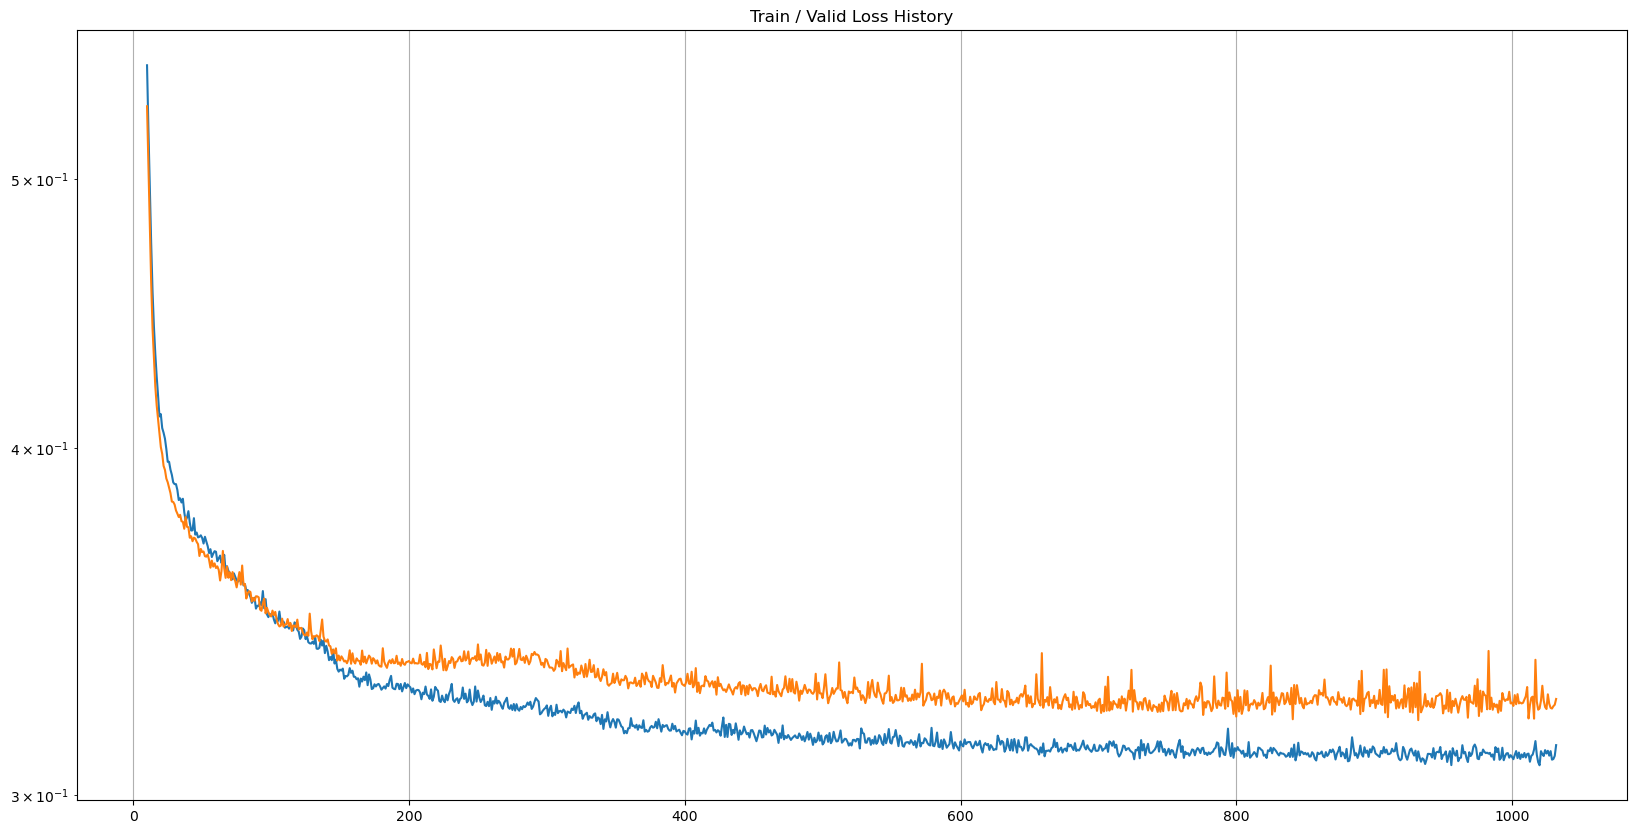

In [44]:
plot_from = 10  # epoch 번호 

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")

# 훈련 손실과 검증 손실을 그래프로 그리기
# range(plot_from, len(train_history)) x축에 해당하는 에포크 번호의 범위 설정
# train_history[plot_from:], valid_history[plot_from:] 
# >> y축에 해당하는 손실 값의 범위를 설정
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:], 
    # 훈련 손실 그래프
    range(plot_from, len(valid_history)), valid_history[plot_from:],
    # 검증 손실 그래프 
)
plt.yscale('log')
# # y축을 로그 스케일로 설정 >> 손실 값의 변화를 더 잘 볼 수 있게 함
plt.show()

## Let's see the result!

In [45]:
test_loss = 0
y_hat = []

# 그래디언트를 계산하지 않도록 설정 (평가 시에는 필요 없음)
with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    # 테스트 데이터를 배치 크기로 분할
    y_ = y[2].split(batch_size, dim=0)
    # 테스트 라벨을 배치 크기로 분할

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
# 평균 테스트 손실 계산
y_hat = torch.cat(y_hat, dim=0)
# 배치별로 나누어진 예측값을 하나의 텐서로 결합

# 훈련 손실과 검증 손실을 정렬 (검증 손실 기준 오름차순)
sorted_history = sorted(zip(train_history, valid_history),
                        key=lambda x: x[1])

print("Train loss: %.4e" % sorted_history[0][0])
# 가장 낮은 검증 손실에 대응하는 훈련 손실 출력
print("Valid loss: %.4e" % sorted_history[0][1])
# 가장 낮은 검증 손실 출력

print("Test loss: %.4e" % test_loss)

Train loss: 3.1113e-01
Valid loss: 3.1929e-01
Test loss: 3.2956e-01


In [48]:
sorted_history[:5]
# 훈련 손실(train_history)과 검증 손실(valid_history)을 
# (train_loss, valid_loss) 형태의 튜플로 묶어 리스트로 만든 후, 
# 검증 손실 기준으로 오름차순 정렬한 리스트

[(0.31113353432441243, tensor(0.3193)),
 (0.30971374377912403, tensor(0.3195)),
 (0.3115925405706678, tensor(0.3197)),
 (0.3105501228449296, tensor(0.3197)),
 (0.30838520490393345, tensor(0.3199))]

In [49]:
sorted_history[0]
# 검증 손실이 가장 낮은 첫 번째 요소(튜플)

(0.31113353432441243, tensor(0.3193))

          y     y_hat
0     1.306  1.228161
1     2.712  3.096991
2     3.201  3.315948
3     1.962  1.905583
4     1.313  1.442475
...     ...       ...
4123  1.621  1.769882
4124  1.382  1.195822
4125  3.384  3.710021
4126  1.704  1.772547
4127  1.102  1.128721

[4128 rows x 2 columns]


c:\Users\ppos7\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ppos7\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


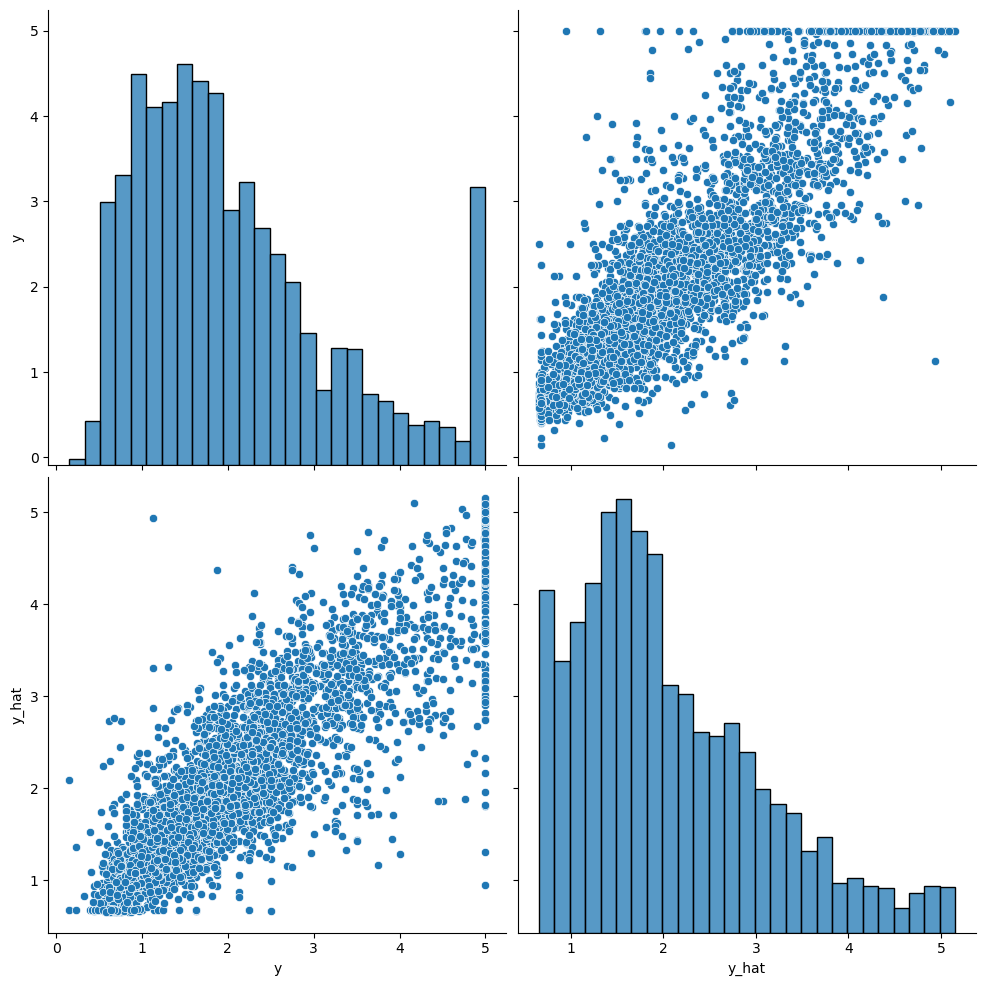

In [50]:
df = pd.DataFrame(torch.cat([y[2], y_hat], dim=1).detach().numpy(),
                  columns=["y", "y_hat"])
# y[2] : y_real
# detach(): 텐서에서 그래디언트 계산을 분리

print(df)

sns.pairplot(df, height=5)
plt.show()